In [23]:
from helper_functions import *
from IPython.display import Image


Aim : To implement the algorithm found in this paper : https://arxiv.org/abs/2012.13453

Overview of the paper : Use of evolutionary algorithm to minimize the cost function so as to estimate the ground state for a model. The evolutionary algorithm part involves inserting/deleting/modifying quantum gates at random locations in the quantum circuit.

In practice, Variational Quantum Eigensolvers (VQEs) suffer from the large quantum computational overhead in estimating cost function gradients for large parameter sets. Here, we consider weight-agnostic learning and investigate the use of evolutionary algorithms which first spawn circuit’s offspring and then evaluate them via genetic competition, thus circumventing some of the previous issues common to parameter-based approaches. We use our methods to solve the transverse field Ising Hamiltonian and the Sherrington-Kirkpatrick spin model.


Following figure shows the outline of evolutionary circuit discovery: Starting with a random initial parent with known loss value, we create copies and mutate them using our custom mutation strategy using operations as shown on the right side of the image. The offspring population is then evaluated on the quantum machine. The circuit with lowest loss value (the original parent included) becomes the parent circuit of the next generation. This procedure is repeated until an appropriate convergence criterion is satisfied. 

![title](images/5.png)

The mutation performs one of 4 actions with certain probabilities, we show these on the right side of above image. <br>
INSERT: Add random gate at random position; <br>
DELETE: Delete gate at random position; <br>
SWAP: Replace gate at random position with random new gate; <br>
MODIFY: Change parameter of gate at random position.<br>




In [ ]:
#![title](images/6.png)

![title](images/6.png)

The above figure shows circuit diagram of the gradual evolution of the circuit architecture for the transverse field Ising Hamiltonian, (Left) after 10 generations and (Right) after 150 generations. <br>
The notation Ri represents a rotation gate wrt axis i (for the purpose of clarity the explicit rotation’s angles are omitted). Note that gates spanning multiple qubits are only applied to the upper- and lowermost qubit. Note that by generation 150 some previously present gates with redundant parameters are removed. Moreover, the circuit generally reflects intelligence in its design and indeed is nicely aligned with the expected useful set of gates for the TFI problem.


To implement the evolution, at each generation, we maintain a variable called "current_circuit" which contains the current state of circuit in special format. <br>
The format is: <br>
   

current_circuit = \[ [gates_of_qubit0], [gates_of_qubit1], [gates_of_qubit2], [gates_of_qubit3], ...., [gates_of_qubit8], [gates_of_qubit9] \] <br>
where "gates_of_qubitn" is a list of gates (in correct order) that are applied to qubit n <br>
Ex:
        If <br>
        0th qubit has Ry, <br>
        1st qubit has Rx and then  Ry, <br>
        2nd qubit has Rxx, <br>
        3rd qubit has Ryy and then  Rzz and then Rx, <br>
        4th qubit has Rxx and then  Ry, <br>
        5th qubit has Rzz, <br>
        6th qubit has no gate, <br>
        7th qubit has Rx and then  Rz, <br>
        8th qubit has Ryy, <br>
        9th qubit has Ry, <br>
        
Then,


In [13]:
current_circuit = [[['Ry', 1.2]], 
 [['Rx', 6.1], ['Ry', 3.9]], 
 [['Rxx', 3.3, 4, 0]], 
 [['Ryy', 6.1, 8, 0], ['Rzz', 4.1, 5, 0], ['Rx', 5.7]], 
 [['Rxx', 3.3, 2, 0], ['Ry', 1.5]],
 [['Rzz', 4.1, 3, 1]], 
 [],
 [['Rx', 0.9], ['Rz', 4.4]],
 [['Ryy', 6.1, 3, 0]],
 [['Ry', 4.2]]]

Each gate is defined as: <br>  <br>
If single gate, \[ "Gate type" , "Gate Argument" \] <br> For ex: \['Ry', 4.2\] <br> <br>
If double gate, \[ "Gate type" , "Gate Argument", "Qubit no. of the other qubit" , "Index where this gate is applied to other qubit" \] <br> For ex: \['Rzz', 4.1, 3, 1\] <br>

Now let's try to use these 4 functions - Insert, Delete, Swap, Modify

We start with an empty circuit

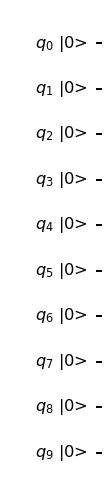

In [43]:
current_circuit=[[] for i in range(10)]
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We now apply insert function to this circuit

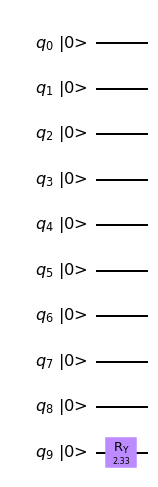

In [44]:
current_circuit=insert(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

Let's now apply insert function multiple times to add more gates

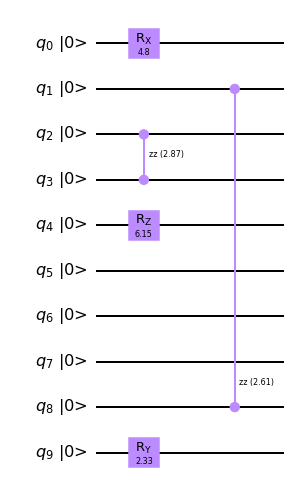

In [45]:
current_circuit=insert(current_circuit)
current_circuit=insert(current_circuit)
current_circuit=insert(current_circuit)
current_circuit=insert(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We now apply delete function to this circuit

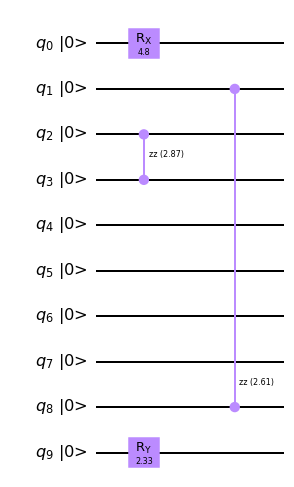

In [46]:
current_circuit=delete(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We see that the Rz gate (on qubit 4) gets removed by the delete operation

We now apply swap function to this circuit

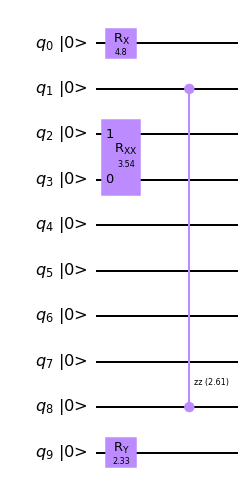

In [47]:
current_circuit=swap(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We see that the Rzz gate (between qubits 2 and 3) gets swapped by the Rxx gate

We now apply mopdify function to this circuit

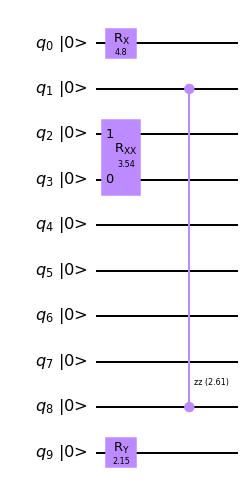

In [49]:
current_circuit=modify(current_circuit)
qiskit_circuit=get_circuit(current_circuit)
qiskit_circuit.draw(initial_state=True, output="mpl")

We see that the Ry gate (on qubit 9) gets its parameter changed from 2.33 to 2.15

Evolutionary algorithms (EA) iteratively work with a population of solution candidates, and optimization is carried out over a number of generations. In each generation, μ candidates that constitute the parent population produce an offspring population of λ candidates by means of crossover and mutation; these operations are specific to the problem domain at hand.

In our application, candidates are quantum circuits, and mutations cause small changes to the
circuit, such as addition or removal of a gate, or nudging of a gate’s parameter. The newly obtained
offspring candidates are evaluated with respect to the loss function and sorted into the
parent population, replacing parents with higher loss value. This selection step emulates natural
selection in biology, where better adapted individuals survive. 


As the parent population is maintained during selection, the best individual that was ever observed since the first generation always survives. This property is known as elitism and ensures that the overall best loss value always monotonically decreases over time. The μ best candidates proceed to form the parent population of the next generation. If none of the offspring individuals yields an improvement, the original parent population carries over to the next generation unchanged. This EA scheme is known in literature as a (μ + λ) EA and is among the most representative and best-understood evolutionary optimization strategies.

In [ ]:
#\\( U_c \: \epsilon \: \mu \\)

Using an evolutionary algorithm we attempt to find a circuit \\( U_c \: \epsilon \: \mu \\) , which performs best with respect to some cost function f. <br>
Every circuit \\( U_c \\) is a product of unitary matrices such that \\( U_c \: = \Sigma _i \: U_i \\) , each of which is defined by generator and a parameter pair ( \\( g_i , \theta _i \\) ) , i.e.

![title](images/7.png)

In this notation \\( g_i \\) denotes an element of a set of Pauli-generators G for experiments chosen to be

![title](images/8.png)

with \\( \mu \: \epsilon \: \{x,y,z\} \\) and  \\(i \neq j \\) and \\( 1 \: \leq i,j  \: \leq n \\)

For each circuit there is an associated value defined by the expectation with respect to some target Hamiltonian H, <br> written in density matrix formulation with | \\( \psi _0  \\) > as initial state:


![title](images/9.png)

Finding a circuit \\( U_opt \\) which minimizes \\( f \\) is an optimization task over the search space \\( \mu \\). This
space \\( \mu \\) is defined through a mix of discrete and continous values, namely generators \\( g_i \\) and qubit
indices and parameters \\( \theta _i \\), respectively. While traditional gradient methods can optimize only the
real-valued parameters \\( \theta _i \\) on fixed circuit layouts, they cannot learn the overall circuit structure,
because the existence or non-existence of a gate, for instance, is not differentiable.


We use the publicly available quantum computing library qiskit to define and modify quantum
circuits in Python. This library is also capable of simulating quantum computing, both by
calculating amplitudes analytically and by simulating shots. <br> <br>
We use a custom EA implementation to perform a (1+4)-EA using a special multi-level mutation
strategy, which we explain in the following paragraph. The optimization run starts with a minimal
random circuit, consisting of only a single gate with a uniformly sampled parameter. From this
initial parent circuit we make 4 copies and mutate them independently using our mutation strategy,
which yields the offspring population. From the measurement results we derive a loss value, which we explain in detail
in another paragraph further down this section. The entire population is then sorted by loss
value, and the circuit with lowest loss becomes the new parent circuit for the next generation.
This process is repeated for 150 generations, during which the parent’s loss value monotonically
decreases, approaching the global optimum.


Mutation strategy: <br> <br>
The mutation strategy consists of a two-level random process. In a first
step, we choose an action from a list of options. Then, we sample parameters for the chosen
action and apply the changes directly to the circuit object. Possible actions (with their respective
occurrence probabilities in parentheses) are: <br> <br>
• INSERT (50%): Sample generator g and parameter theta uniformly and insert the corresponding
gate at a random position. <br>
• DELETE (10%): Delete gate at a random position from the circuit. <br>
• SWAP (10%): Combination of Delete and Insert at the same randomly chosen position <br>
• MODIFY (30%): Modify parameter of randomly chosen gate according to theta = theta+ \\( \epsilon \\) with \\( \epsilon \approx N(0,0.01)\\).


The difficulty to find the minimal eigenvalue to a Hamiltonian is intimately tied to the entanglement
of its ground state. Intuitively, the more entanglement required the more intricate the optimization
landscape is. Therefore, we are first interested in our algorithms capability to perform in these
non-convex circumstances.
To gradually
raise difficulty we transition in three steps from a maximally local problem to a spin-glass model
only consisting of non-local terms. This gives us a chance test our algorithms capability to
optimize increasingly difficult problems.

